In [43]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from matplotlib import pyplot as plt
from glob import glob

import entity
import json
import pandas as pd
import os
import numpy as np

In [2]:
vs = SentimentIntensityAnalyzer()
entities = entity.Entity()

In [3]:
json_data = None
with open("data/test.json") as json_file:
    json_data = json.load(json_file)

In [4]:
def get_json_data(json_data):
    '''
    @param json_data: [ {content:'', title:'', keywords:'', sector:''}, ... ]
    @return: tuple of (title, keywords, content)
    '''
    for article in json_data:
        if article['sector'] in ['Technology', 'Markets']:
            yield (article['news_title'], article['keywords'], article['content'])

In [5]:
g = get_json_data(json_data)

In [6]:
def get_entities_from_article_content(article_content):
    '''
    @param article_content: non-processed string of content
    @return set of entity names found in article_content
    '''
    global entities
    articleEntities = entities.getSelectNamedEntities(['ORG','PERSON'],article_content)
    entityNames = entities.createEntitySet(articleEntities)
    if " " in entityNames:
        entityNames.remove(" ")
    return entityNames

In [7]:
def clean_article_content(article_content):
    '''
    @param article_content: non-processed string of content
    @return array of lower-case sentences
    '''
    cleaned = []
    for sent in sent_tokenize(article_content):
        cleaned.append(sent.lower())
    return cleaned

In [8]:
def get_total_article_sentiment_score(article_content):
    '''
    @param article_content: non-processed string of content
    @return average document score
    '''
    global vs
    score = 0
    sentences = sent_tokenize(article_content)
    for sent in sentences:
        score += vs.polarity_scores(sent)['compound']
    
    return score / len(sentences)

In [9]:
def get_words_around_entity(entities, word_window_size, sentence_array):
    '''
    @param entities: set of entites to locate
    @param word_window_size: the maximum number of words to consider part of context around entity
    @param sentence_array: cleaned array of sentences which may or may not contain entities
    @return dictionary mapping each entity to each context it occurs in
    
    >>> get_words_around_entity(set('mark'), 2, ['i am friends with mark because he is a cool dude'])
    {'mark':['friends with mark because he]}
    
    >>> get_words_around_entity(set('toronto maple leafs'), 2, ['the guy will join the toronto maple leafs'])
    {'toronto maple leafs':['join the toronto maple leafs']}
    
    '''
    entity_context_map = {}
    for e in entities:
        
        contexts = []
        
        for s in sentence_array:
            if e in s:
                lhs, _, rhs = s.partition(e)
                lhs = lhs.split()[-word_window_size:]
                rhs = rhs.split()[:word_window_size]
                
                contexts.append(" ".join(lhs + [e] + rhs))
                
        entity_context_map[e] = contexts
        
    return entity_context_map

In [10]:
def get_sent_scores_per_entity(entity_context_map):
    '''
    @param entity_context_map: dictionary of {entity:[list of context/sentences entity occurs in]}
    @return dictionary of {entity: average sentiment score given context} 
    '''
    global vs
    entity_sent_map = {} 
    for e, context in entity_context_map.items():  
        if len(context) == 0:
            continue
        e_score = 0
        for sentence in context:
            e_score += vs.polarity_scores(sentence)['compound']
        entity_sent_map[e] = e_score / len(context)
    return entity_sent_map

In [11]:
def get_sentiment_difference(doc_score, entity_score_map):
    '''
    @param doc_score: float representing the document level sentiment score of an article
    @param entity_score_map: {entity:sentiment_score} for each entity in the same article
    @return total 'distance' between all entity scores and document score
    '''
    total_difference = 0;
    for entity, score in entity_score_map.items():
        total_difference += abs(doc_score - score)
        
    return total_difference

In [16]:
def get_record_info(json_data):
    '''
    For each article in a record:
        (1) Calculate the article score
        (2) Get the entities
        (3) Clean the sentences
        (4) Get the context for each entity
        (5) Compute the sentiment scores for each entity
        (6) Compute the summed unsigned distance between the document score and all the entity scores
        
    @param json_data: 
    '''
    ss = []
    for t,k,c in get_json_data(json_data):
        doc_score = get_total_article_sentiment_score(c)
        ents = get_entities_from_article_content(c)
        sentences = clean_article_content(c)
        ent_score_15 = get_sent_scores_per_entity(get_words_around_entity(ents, 15, sentences))
        ent_score_10 = get_sent_scores_per_entity(get_words_around_entity(ents, 10, sentences))
        ent_score_5 = get_sent_scores_per_entity(get_words_around_entity(ents, 5, sentences))
        dif_5 = get_sentiment_difference(doc_score, ent_score_5)
        dif_10 = get_sentiment_difference(doc_score, ent_score_10)
        dif_15 = get_sentiment_difference(doc_score, ent_score_15)

        
        s = pd.Series({
            'name':t,
            'doc_score':doc_score,
            'ent':ents,
            'ent_score_5':ent_score_5,
            'ent_score_10':ent_score_10,
            'ent_score_15':ent_score_15,
            'dif_5':dif_5,
            'dif_10':dif_10,
            'dif_15':dif_15
        })
        
        ss.append(s)
        
    
    return pd.DataFrame(ss)

In [13]:
df = get_record_info(json_data)

In [14]:
df.head()

,dif,doc_score,ent_scores,entities,name
0,2.957631,0.086328,"{'blake/file': 0.0, 'phototoshiba': 0.0, 'west...","{blake/file, phototoshiba, western digital, al...",Exclusive: Toshiba aims to name buyer of $18 b...
1,3.315500,0.224240,"{'tpg capital management': 0.2732, 'chien wong...","{tpg capital management, chien wong, hutchison...",CORRECTED-Hutchison's fixed-line biz draws int...
2,1.656255,0.204159,"{'norinchukin research institute': 0.0, 'reute...","{norinchukin research institute, reuters, cabi...",Japan's first quarter growth halved by oil inv...
3,5.337483,0.278367,"{'tpg capital management': 0.2732, 'hkbn ltd':...","{tpg capital management, hkbn ltd, carol zhong...",CORRECTED-UPDATE 1-Hutchison's fixed-line biz ...
4,0.000000,0.000000,"{'sue-lin wong': 0.0, 'customs': 0.0, 'reuters...","{sue-lin wong, customs, reuters, the general a...",BRIEF-China May yuan-denominated exports rise ...


# Issues

* Entities contain soft duplicates (e.g. 'western digital', 'western digital corp', 'western digital corporation')
* Need a better scoring function (if doc D has entities A and B each of score 0, score(D) = 1, distance(D, entities(D)) should be 0. Or should they? Brain is fried)- look at dfs[16] for my confusion

In [17]:
def get_data(path):
    '''
    @param path: something like 'data/*.json' - path to directory of json
    @return dataframe
    '''
    dfs = []
    for file in path:
        with open(file) as json_file:
            dfs.append(get_record_info(json.load(json_file)))
            print(f"done with file {file}")
            
            
    return pd.concat(dfs, ignore_index=True)

In [18]:
def sort_files(fs):
    f1 = [(f, os.path.getsize(f)) for f in fs] # sort files by size
    f1 = sorted(f1, key=lambda t:t[1])
    return [f for f,_ in f1]

In [19]:
dfs = get_data(sort_files(glob('data/*.json')))

done with file data/test.json
done with file data/20170611.json
done with file data/20170702.json
done with file data/20170618.json
done with file data/20170625.json
done with file data/20170709.json
done with file data/20170626.json
done with file data/20170619.json
done with file data/20170703.json
done with file data/20170612.json
done with file data/20170710.json
done with file data/20170705.json
done with file data/20170704.json
done with file data/20170708.json
done with file data/20170624.json
done with file data/20170617.json
done with file data/20170711.json
done with file data/20170627.json
done with file data/20170706.json
done with file data/20170712.json
done with file data/20170701.json
done with file data/20170707.json
done with file data/20170620.json
done with file data/20170607.json
done with file data/20170614.json
done with file data/20170628.json
done with file data/20170613.json
done with file data/20170610.json
done with file data/20170622.json
done with file dat

In [21]:
dfs.max()

dif_10                                 273.563
dif_15                                 268.066
dif_5                                  263.936
doc_score                               0.9978
ent          {industrial bank co ltd, reuters}
name               東芝、半導体子会社売却先・日米韓連合で最終調整＝関係筋
dtype: object

In [121]:
dfs.shape

(22395, 9)

In [57]:
dfs.min()

dif                                                          0
doc_score                                              -0.4017
entities                                                    {}
name         15 dead, scores missing hours after landslide ...
dtype: object

In [58]:
dfs['entities']

0      {blake/file, phototoshiba, western digital, al...
1      {tpg capital management, chien wong, hutchison...
2      {norinchukin research institute, reuters, cabi...
3      {tpg capital management, hkbn ltd, carol zhong...
4      {sue-lin wong, customs, reuters, the general a...
5      {sue-lin wong, reuters, the general administra...
6                        {jiangsu etern co ltd, reuters}
7      {montblanc, kempinski hotels sa, daniel flynn,...
8                      {reuters, guanghui energy co ltd}
9      {tianmushan pharmaceutical enterprise co ltd, ...
10     {the european central bank, jacqueline wong, t...
11     {the european central bank, moody's, inflows r...
12       {china fineblanking technology co ltd, reuters}
13     {ningbo tianlong electronics co ltd, reuters, ...
14              {jv, shanghai yaoji playing card co ltd}
15             {nippon prologis reit inc, reuters, reit}
16            {ningbo jifeng auto parts co ltd, reuters}
17                             

In [32]:
# plt.plot(dfs['doc_score'])
dfs.mean()

dif_10       1.810494
dif_15       1.756589
dif_5        1.843843
doc_score    0.248691
dtype: float64

In [33]:
dfs.median()

dif_10       1.205700
dif_15       1.049400
dif_5        1.325729
doc_score    0.177190
dtype: float64

In [34]:
dfs.std()

dif_10       3.336902
dif_15       3.416988
dif_5        3.241216
doc_score    0.365843
dtype: float64

In [37]:
d1 = dfs[dfs.dif_10 < 20]
d2 = dfs[dfs.dif_10 >= 20]

In [38]:
d1.size

201366

In [39]:
d2.size

189

In [40]:
d1.std()

dif_10       1.893844
dif_15       2.040526
dif_5        1.802483
doc_score    0.365814
dtype: float64

In [42]:
d1.min()

dif_10                                                       0
dif_15                                                       0
dif_5                                                        0
doc_score                                              -0.9892
ent                                                         {}
name         'Brain training' app improves memory in people...
dtype: object

In [44]:
np.mean([len(e) for e in dfs['ent']])

7.799553471757089

In [45]:
np.median([len(e) for e in dfs['ent']])

5.0

In [47]:
dfs.describe()

,dif_10,dif_15,dif_5,doc_score
count,22395.000000,22395.000000,22395.000000,22395.000000
mean,1.810494,1.756589,1.843843,0.248691
std,3.336902,3.416988,3.241216,0.365843
min,0.000000,0.000000,0.000000,-0.989200
25%,0.410313,0.241009,0.500000,0.000000
50%,1.205700,1.049400,1.325729,0.177190
75%,2.487069,2.385250,2.553000,0.510600
max,273.562800,268.065500,263.935500,0.997800


In [66]:
d1 = dfs[dfs.dif_10 < 40]

In [70]:
d1.shape

(22389, 9)

In [74]:
(6/22395) * 100

0.026791694574681845

In [77]:
d1.describe()

,dif_10,dif_15,dif_5,doc_score
count,22389.000000,22389.000000,22389.000000,22389.000000
mean,1.771425,1.717371,1.805623,0.248720
std,2.008462,2.152325,1.920547,0.365736
min,0.000000,0.000000,0.000000,-0.989200
25%,0.410100,0.240800,0.500000,0.000000
50%,1.205450,1.049000,1.324900,0.177190
75%,2.486100,2.383780,2.551920,0.510600
max,37.489767,37.278967,37.146600,0.997800


In [78]:
d11 = d1.describe()

In [81]:
d1['ent_len'] = pd.Series([len(e) for e in d1['ent']])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [125]:
sum([len(e) for e in d1['ent']]) / len(d1['ent'])

7.739916923489213

In [82]:
d1.describe()

,dif_10,dif_15,dif_5,doc_score,ent_len
count,22389.000000,22389.000000,22389.000000,22389.000000,22383.000000
mean,1.771425,1.717371,1.805623,0.248720,7.740741
std,2.008462,2.152325,1.920547,0.365736,8.717174
min,0.000000,0.000000,0.000000,-0.989200,0.000000
25%,0.410100,0.240800,0.500000,0.000000,3.000000
50%,1.205450,1.049000,1.324900,0.177190,5.000000
75%,2.486100,2.383780,2.551920,0.510600,9.000000
max,37.489767,37.278967,37.146600,0.997800,131.000000


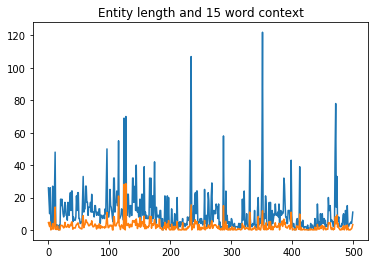

In [127]:
plt.plot(d1['ent_len'][:500])
plt.plot(d1['dif_15'][:500])
plt.title("Entity length and 15 word context")
# plt.savefig('./ent_len_15.png')
plt.show()
# plt.plot(d1['dif_10'][:500])
# plt.title("10 word context")
# plt.show()
# plt.plot(d1['dif_5'][:500])
# plt.title("5 word context")
# plt.show()

In [110]:
d1[d1.dif_10 > 3]['name'].shape

(4288,)

In [112]:
d1.describe().to_latex('./difs_and_ent.tex')

In [119]:
d1['ent_len'].mean()

7.7407407407407405

In [131]:
d1[d1.ent_len > 100]['ent'][858]

{'commercial real estate investment trust',
 'commercial real estate ltd',
 'eur40.7',
 'reuters'}

In [144]:
[len(e) for e in d1['ent']]

[26,
 18,
 10,
 26,
 4,
 4,
 2,
 27,
 2,
 2,
 26,
 48,
 2,
 3,
 2,
 3,
 2,
 0,
 3,
 1,
 19,
 15,
 19,
 15,
 10,
 8,
 10,
 17,
 15,
 9,
 9,
 6,
 17,
 10,
 9,
 19,
 23,
 12,
 24,
 24,
 5,
 8,
 6,
 6,
 6,
 8,
 21,
 12,
 23,
 23,
 7,
 7,
 4,
 4,
 5,
 5,
 19,
 33,
 11,
 13,
 13,
 27,
 27,
 17,
 17,
 9,
 14,
 14,
 14,
 17,
 11,
 22,
 11,
 11,
 11,
 8,
 15,
 15,
 11,
 9,
 11,
 10,
 9,
 13,
 13,
 4,
 9,
 9,
 8,
 7,
 9,
 9,
 7,
 13,
 10,
 30,
 50,
 12,
 8,
 8,
 12,
 25,
 15,
 14,
 11,
 7,
 5,
 32,
 32,
 11,
 17,
 17,
 24,
 15,
 15,
 55,
 7,
 7,
 8,
 9,
 13,
 10,
 10,
 6,
 69,
 5,
 4,
 70,
 13,
 9,
 22,
 22,
 11,
 8,
 15,
 15,
 9,
 9,
 32,
 32,
 17,
 20,
 27,
 12,
 40,
 13,
 11,
 14,
 8,
 8,
 19,
 5,
 10,
 22,
 22,
 9,
 10,
 39,
 7,
 11,
 7,
 9,
 7,
 7,
 7,
 9,
 32,
 14,
 32,
 5,
 21,
 21,
 7,
 20,
 42,
 11,
 4,
 14,
 9,
 8,
 9,
 9,
 7,
 12,
 12,
 2,
 2,
 7,
 0,
 4,
 3,
 21,
 14,
 3,
 14,
 21,
 2,
 20,
 2,
 3,
 3,
 2,
 13,
 6,
 2,
 4,
 3,
 10,
 2,
 6,
 7,
 20,
 2,
 1,
 4,
 5,
 2,
 5,
 4,
 3,
 7,

In [151]:
d1['ent_score_15'][60]

{'christopher cushing': 0.0,
 'galaxy': 0.3149,
 'galaxy note 7': 0.29295,
 'galaxy note 7 fan edition': 0.5859,
 'note 7s': 0.2990333333333333,
 'reuters': 0.0,
 's8': 0.5859,
 'samsung': 0.21509999999999999,
 'samsung electronics co ltd': 0.0,
 'se young lee': 0.0,
 'the note 7 in october': -0.4588,
 "the note 7's": 0.5859,
 'the note 8': 0.0}